In [1]:
import re
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET 

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay


In [2]:
path = input('Chemin :\n')
if path.lower() == 'i':
    path = '/Users/admin1/Documents/deft_2009 2/data/'
else:
    path = ''
    

# Récupération des données de train

In [3]:
def extract_train(path):
    '''Fonction qui permet l'extraction du texte et du parti pour le corpus de train'''
    list_target =[] 
    list_text =[]
    tree= ET.parse(path)
    root= tree.getroot()
    doc= root.findall('doc')
    for doc in root.findall('doc') :
        parti= doc.find(".//PARTI")
        val= parti.get("valeur")
        list_target.append(val)

        texte = doc.find('texte')
        if texte is not None:
            textesanspar = re.sub(r'\xa0|\n|<texte>|</texte>|<p>|</p>', '', ET.tostring(texte, 'utf-8').decode('utf-8'))
            textesanspar = re.sub(r'[^\w\s\']|[0-9]', ' ', textesanspar)
            list_text.append(textesanspar) 
    return list_text, list_target

## Extraction des données du train

In [4]:
train_text_en, train_target_en = extract_train(f'{path}train/deft09_parlement_appr_en.xml')
train_text_fr, train_target_fr = extract_train(f'{path}train/deft09_parlement_appr_fr.xml')
train_text_it, train_target_it = extract_train(f'{path}train/deft09_parlement_appr_it.xml')

In [6]:
print(len(train_target_en))
print(len(train_target_fr))
print(len(train_target_it))

19370
19370
19370


# Récupération des données de test

## Extraction du texte

In [5]:
def extract_text_test(path):
    '''Fonction qui permet l'extraction du texte pour le corpus de test'''
    liste_text=[]
    tree= ET.parse(path)
    root= tree.getroot()
    docs= root.findall('doc')
    for doc in docs:
        texte = doc.find('texte')
        if texte is not None:
            textesanspar = re.sub(r'\xa0|\n|<texte>|</texte>|<p>|</p>', '', ET.tostring(texte, 'utf-8').decode('utf-8'))
            textesanspar = re.sub(r'[^\w\s\']|[0-9]', ' ', textesanspar)
            liste_text.append(textesanspar)
    return liste_text


In [6]:
test_text_en = extract_text_test(f'{path}test/deft09_parlement_test_en.xml')
test_text_fr = extract_text_test(f'{path}test/deft09_parlement_test_fr.xml')
test_text_it = extract_text_test(f'{path}test/deft09_parlement_test_it.xml')

In [9]:
print(len(test_text_en))
print(len(test_text_fr))
print(len(test_text_it))

12917
12917
12917


## Extraction du parti

In [7]:
def extract_train_test(path):
    '''Fonction qui permet l'extraction du parti pour le test'''
    liste_target = []
    with open(path) as file:
        for line in file:
            enliste=line.strip('\n').split('\t')
            liste_target.append(enliste[1])
    return liste_target

In [8]:
test_target_en = extract_train_test(f'{path}ref/deft09_parlement_ref_en.txt')
test_target_fr = extract_train_test(f'{path}ref/deft09_parlement_ref_fr.txt')
test_target_it = extract_train_test(f'{path}ref/deft09_parlement_ref_it.txt')

# 1. Modèles pour toutes les langues 

## Vectorisation

### Récupération des listes de stops words de Spacy


In [9]:
en = spacy.load("en_core_web_sm")
fr = spacy.load("fr_core_news_sm")
it = spacy.load("it_core_news_sm")

stopwordsen = list(en.Defaults.stop_words)
stopwordsfr = list(fr.Defaults.stop_words)
stopwordsit = list(it.Defaults.stop_words)

### Vectorisation du train et test

In [10]:
stopwords=[*stopwordsen,*stopwordsfr,*stopwordsit]
train_text=[*train_text_en,*train_text_fr,*train_text_it]
test_text=[*test_text_en,*test_text_fr,*test_text_it]

In [14]:
print(len(train_text))

58110


In [11]:
vectorizer = TfidfVectorizer(stop_words = stopwords, min_df=10)

X_train = vectorizer.fit_transform(train_text)
X_test = vectorizer.transform(test_text)

features = vectorizer.get_feature_names_out()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gl', 'll', 'neuf', 'nient', 'qu', 'quelqu', 've'] not in stop_words.
  warnings.warn(


## Preparation des targets

- On remarque qu'il existe des targets vides dans le test pour lesquelles le texte associé ne contient que les balises paragraphes. On crée ainsi une classe vide pour ces textes.

In [12]:
target_labels = ["GUE-NGL", "PSE", "PPE-DE", "ELDR", "Verts-ALE"]

for indice, element in enumerate(test_target_en):
    if element not in target_labels:
        print(indice)
        

2601
12171


In [13]:
def dico(target_text):
    target=[]
    dico={'GUE-NGL':0,'PSE':1 ,'PPE-DE':2,'ELDR':3,'Verts-ALE':4, '':5}
    for parti in target_text:
        for cle,val in dico.items():
            if cle == parti:
                target.append(val)
    return np.array(target)


In [14]:
y_train =dico([*train_target_en,*train_target_fr,*train_target_it])
y_test = dico([*test_target_en,*test_target_fr,*test_target_it])

In [15]:
y_train_en= dico(train_target_en)
y_train_fr= dico(train_target_fr)
y_train_it = dico(train_target_it)

y_test_en= dico(test_target_en)
y_test_fr= dico(test_target_fr)
y_test_it= dico(test_target_it)

## Visualisation des données 

In [ ]:
result = pd.DataFrame(
    data=X_train, 
    index=y_train,
    columns= features
)

result


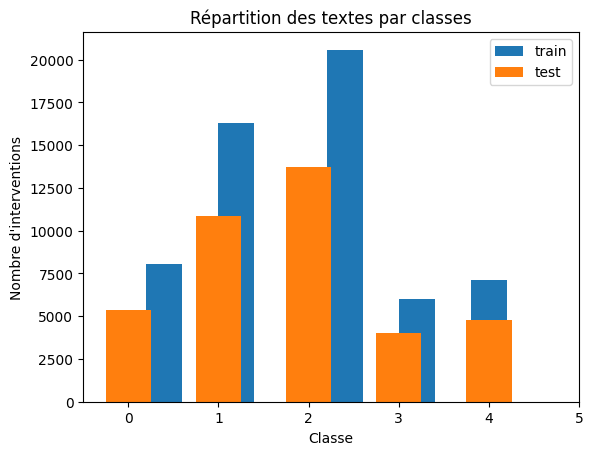

In [79]:
%matplotlib inline

plt.hist(y_train, align="right", label="train") 
plt.hist(y_test, align="left", label="test")
plt.legend()
plt.xlabel("Classe")
plt.ylabel("Nombre d'interventions")
plt.title("Répartition des textes par classes") 
plt.show()

## Classifieurs

### SVC

In [31]:
clf = LinearSVC()
clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [32]:
clf.predict(X_test)

array([1, 2, 4, ..., 1, 0, 4])

In [33]:
clf.score(X_test, y_test)

0.7342778250883848

In [34]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80      5379
           1       0.69      0.71      0.70     10881
           2       0.72      0.81      0.76     13713
           3       0.78      0.61      0.68      4017
           4       0.76      0.63      0.69      4755
           5       0.00      0.00      0.00         6

    accuracy                           0.73     38751
   macro avg       0.63      0.59      0.61     38751
weighted avg       0.74      0.73      0.73     38751



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

### Naive Bayes

In [52]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

MultinomialNB()

In [53]:
MNB.predict(X_test)

array([2, 2, 1, ..., 2, 0, 2])

In [54]:
MNB.score(X_test, y_test)

0.47841346029779874

In [55]:
y_pred = MNB.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.26      0.39      5379
           1       0.55      0.38      0.45     10881
           2       0.44      0.94      0.60     13713
           3       1.00      0.00      0.00      4017
           4       0.83      0.03      0.05      4755
           5       0.00      0.00      0.00         6

    accuracy                           0.48     38751
   macro avg       0.62      0.27      0.25     38751
weighted avg       0.64      0.48      0.40     38751



/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

In [20]:
rfc =  RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [21]:
rfc.predict(X_test)

array([1, 2, 4, ..., 1, 0, 4])

In [22]:
rfc.score(X_test, y_test)

0.7778637970633016

In [23]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.74      0.83      5379
           1       0.81      0.72      0.76     10881
           2       0.66      0.94      0.78     13713
           3       0.99      0.63      0.77      4017
           4       1.00      0.62      0.76      4755
           5       0.00      0.00      0.00         6

    accuracy                           0.78     38751
   macro avg       0.73      0.61      0.65     38751
weighted avg       0.82      0.78      0.78     38751



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# 2. Modèles pour chaque langue 

## Vectorisation 

In [21]:
def vectorization(datatrain, datatest,stopWords):
    vectorizer = TfidfVectorizer(stop_words = stopWords, min_df=10)
    X_train = vectorizer.fit_transform(datatrain)
    X_test = vectorizer.transform(datatest)
    features = vectorizer.get_feature_names_out()
    return X_train, X_test, features

In [22]:
X_train_en, X_test_en, features_en = vectorization(train_text_en,test_text_en, stopwordsen)
X_train_fr, X_test_fr, features_fr = vectorization(train_text_fr,test_text_fr, stopwordsfr)
X_train_it, X_test_it, features_it = vectorization(train_text_it,test_text_it, stopwordsit)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'qu', 'quelqu'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gl', 'nient'] not in stop_words.
  warnings.warn(


In [23]:
print(X_train_en.shape)
print(X_train_fr.shape)
print(X_train_it.shape)

(19370, 11949)
(19370, 15770)
(19370, 17215)


## Classifieurs 

### Random Forest

- Paramètres de base du modèle

In [63]:
rf = RandomForestClassifier()
print(rf.get_params())


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


- Essai sur le corpus anglais : 

In [64]:
rf.fit(X_train_en, y_train_en)
y_pred = rf.predict(X_test_en)

In [65]:
accuracy = accuracy_score(y_test_en, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7768831772083301


- Fine tuning des paramètres du modèle sur le corpus anglais :

In [29]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [30]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train_en, y_train_en)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  44.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  44.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  45.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=12

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 3.6min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 1.4min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 6.2min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 1.4min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 6.2min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 6.3min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 1.4min
[CV] END bootstrap=False, max

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
29 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

- Modèle RF anglais :

In [67]:
rfen = RandomForestClassifier(bootstrap=False, min_samples_split=5, n_estimators=800)
rfen.fit(X_train_en, y_train_en)
y_pred_en = rfen.predict(X_test_en)

In [68]:
accuracy_en = accuracy_score(y_test_en, y_pred_en)
print("Accuracy:", accuracy_en)

Accuracy: 0.7871796856855307


In [71]:
print(classification_report(y_test_en, y_pred_en))

              precision    recall  f1-score   support

           0       0.96      0.76      0.84      1793
           1       0.87      0.71      0.78      3627
           2       0.66      0.96      0.78      4571
           3       0.99      0.65      0.78      1339
           4       1.00      0.62      0.76      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.79     12917
   macro avg       0.74      0.62      0.66     12917
weighted avg       0.83      0.79      0.79     12917



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

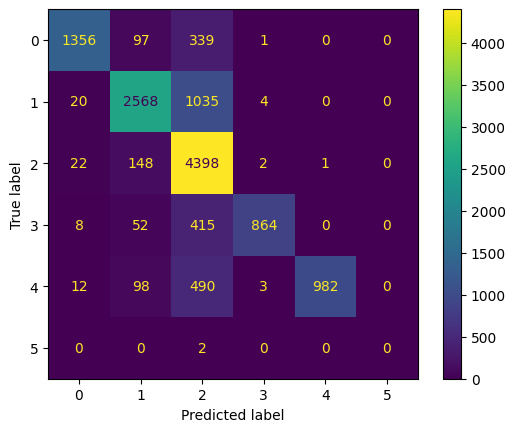

In [70]:
cm_en = confusion_matrix(y_test_en, y_pred_en)

ConfusionMatrixDisplay(confusion_matrix=cm_en).plot()

- Modèle RF français :

In [73]:
rffr= RandomForestClassifier(bootstrap=False, max_depth=500, min_samples_split=5, n_estimators=800)
rffr.fit(X_train_fr, y_train_fr)
y_pred_fr = rffr.predict(X_test_fr)

In [74]:
accuracy_fr = accuracy_score(y_test_fr, y_pred_fr)
print("Accuracy:", accuracy_fr)

Accuracy: 0.783308817836959


In [75]:
print(classification_report(y_test_fr, y_pred_fr))

              precision    recall  f1-score   support

           0       0.94      0.75      0.84      1793
           1       0.86      0.70      0.77      3627
           2       0.66      0.96      0.78      4571
           3       0.99      0.63      0.77      1339
           4       1.00      0.62      0.76      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.78     12917
   macro avg       0.74      0.61      0.65     12917
weighted avg       0.83      0.78      0.78     12917



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

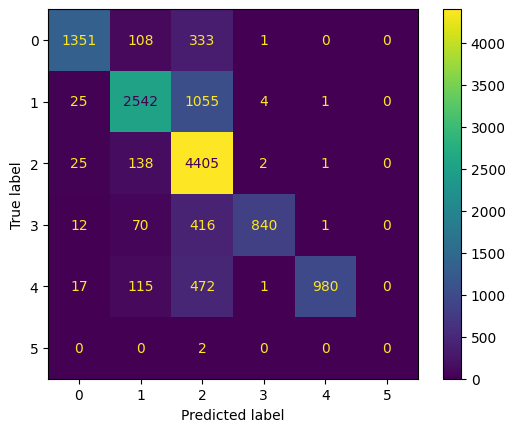

In [76]:
cm_fr = confusion_matrix(y_test_fr, y_pred_fr)

ConfusionMatrixDisplay(confusion_matrix=cm_fr).plot()

- Modèle RF italien :

In [77]:
rfit = RandomForestClassifier(bootstrap=False, max_depth=500, min_samples_split=5, n_estimators=800)
rfit.fit(X_train_it, y_train_it)
y_pred_it = rfit.predict(X_test_it)

In [78]:
accuracy_it = accuracy_score(y_test_it, y_pred_it)
print("Accuracy:", accuracy_it)

Accuracy: 0.7857861732600449


In [79]:
print(classification_report(y_test_it, y_pred_it))
print(rfit.score(X_test_it, y_test_it))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1793
           1       0.87      0.71      0.78      3627
           2       0.66      0.96      0.78      4571
           3       0.99      0.63      0.77      1339
           4       1.00      0.62      0.76      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.79     12917
   macro avg       0.74      0.61      0.66     12917
weighted avg       0.83      0.79      0.79     12917

0.7857861732600449


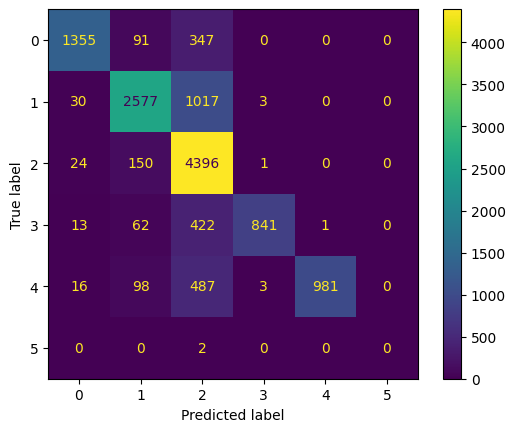

In [81]:
cm_it = confusion_matrix(y_test_it, y_pred_it)

ConfusionMatrixDisplay(confusion_matrix=cm_it).plot()

### Naive Bayes

In [32]:
def finetunning_NBM(X_train, y_train):
    parameters= {
    'alpha':[0, 0.25, 0.5, 0.75, 1],
    'force_alpha': [False,True],
    'fit_prior':[False,True]
    }
    clf= GridSearchCV(MultinomialNB(),parameters,scoring= make_scorer(f1_score),refit= True)
    clf.fit(X_train, y_train)
    return clf.best_params_

In [33]:
best_param_en = finetunning_NBM(X_train_en, y_train_en)
best_param_fr = finetunning_NBM(X_train_fr,y_train_fr)
best_param_it = finetunning_NBM(X_train_it, y_train_it)

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_p

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:903: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_p

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:903: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_p

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

- Modèle NB anglais :

In [34]:
## Pour l'anglais 
MNB = MultinomialNB(**best_param_en)
MNB.fit(X_train_en, y_train_en)

y_pred = MNB.predict(X_test_en)

print(classification_report(y_test_en, y_pred))
print(MNB.score(X_test_en, y_test_en))

              precision    recall  f1-score   support

           0       0.68      0.63      0.66      1793
           1       0.56      0.62      0.59      3627
           2       0.68      0.61      0.64      4571
           3       0.58      0.60      0.59      1339
           4       0.53      0.60      0.56      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.61     12917
   macro avg       0.51      0.51      0.51     12917
weighted avg       0.62      0.61      0.61     12917

0.6120616242161493


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision

- Modèle NB français :

In [35]:
MNB = MultinomialNB(**best_param_fr)
MNB.fit(X_train_fr, y_train_fr)

y_pred = MNB.predict(X_test_fr)

print(classification_report(y_test_fr, y_pred))
print(MNB.score(X_test_fr, y_test_fr))

              precision    recall  f1-score   support

           0       0.74      0.63      0.68      1793
           1       0.59      0.66      0.62      3627
           2       0.69      0.68      0.68      4571
           3       0.63      0.62      0.62      1339
           4       0.60      0.61      0.60      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.65     12917
   macro avg       0.54      0.53      0.54     12917
weighted avg       0.65      0.65      0.65     12917

0.6494542076333514


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision

- Modèle NB italien :

In [36]:
MNB = MultinomialNB(**best_param_it)
MNB.fit(X_train_it, y_train_it)

y_pred = MNB.predict(X_test_it)

print(classification_report(y_test_it, y_pred))
print(MNB.score(X_test_it, y_test_it))

              precision    recall  f1-score   support

           0       0.75      0.63      0.68      1793
           1       0.59      0.66      0.62      3627
           2       0.68      0.68      0.68      4571
           3       0.68      0.60      0.64      1339
           4       0.61      0.60      0.61      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.65     12917
   macro avg       0.55      0.53      0.54     12917
weighted avg       0.65      0.65      0.65     12917

0.6491445382054657


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision

### SVM

- Paramètres par défaut du modèle

In [17]:
clf = LinearSVC()
print(clf.get_params())

{'C': 1.0, 'class_weight': None, 'dual': 'warn', 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


- Modèle SVM anglais

In [21]:
clf.fit(X_train_en, y_train_en)
y_pred = clf.predict(X_test_en)
print(classification_report(y_test_en, y_pred))
print(clf.score(X_test_en, y_test_en))

/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1793
           1       0.68      0.70      0.69      3627
           2       0.71      0.80      0.75      4571
           3       0.79      0.60      0.68      1339
           4       0.74      0.62      0.67      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.72     12917
   macro avg       0.62      0.58      0.60     12917
weighted avg       0.73      0.72      0.72     12917

0.7238522876828986


/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Modèle SVM français

In [22]:
clf.fit(X_train_fr, y_train_fr)
y_pred = clf.predict(X_test_fr)
print(classification_report(y_test_fr, y_pred))
print(clf.score(X_test_fr, y_test_fr))

/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1793
           1       0.70      0.72      0.71      3627
           2       0.72      0.81      0.76      4571
           3       0.81      0.61      0.70      1339
           4       0.77      0.64      0.70      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.74     12917
   macro avg       0.64      0.60      0.61     12917
weighted avg       0.74      0.74      0.74     12917

0.7408841062166137


/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Modèle SVM italien

In [23]:
clf.fit(X_train_it, y_train_it)
y_pred = clf.predict(X_test_it)
print(classification_report(y_test_it, y_pred))
print(clf.score(X_test_it, y_test_it))

/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1793
           1       0.71      0.73      0.72      3627
           2       0.73      0.82      0.77      4571
           3       0.79      0.62      0.70      1339
           4       0.77      0.65      0.71      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.75     12917
   macro avg       0.64      0.60      0.62     12917
weighted avg       0.75      0.75      0.75     12917

0.7462259038476426


/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Changement du paramètre dual en False en Anglais

In [24]:
clf = LinearSVC(dual=False)
clf.fit(X_train_en, y_train_en)
y_pred = clf.predict(X_test_en)
print(classification_report(y_test_en, y_pred))
print(clf.score(X_test_en, y_test_en))


              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1793
           1       0.68      0.70      0.69      3627
           2       0.71      0.80      0.75      4571
           3       0.79      0.60      0.68      1339
           4       0.74      0.62      0.67      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.72     12917
   macro avg       0.62      0.58      0.60     12917
weighted avg       0.73      0.72      0.72     12917

0.723774870325927


/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Changement du paramètre dual en False en Francais

In [25]:
clf = LinearSVC(dual=False)
clf.fit(X_train_fr, y_train_fr)
y_pred = clf.predict(X_test_fr)

print(classification_report(y_test_fr, y_pred))
print(clf.score(X_test_fr, y_test_fr))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1793
           1       0.70      0.72      0.71      3627
           2       0.72      0.81      0.76      4571
           3       0.81      0.61      0.70      1339
           4       0.77      0.64      0.70      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.74     12917
   macro avg       0.64      0.60      0.61     12917
weighted avg       0.74      0.74      0.74     12917

0.7408066888596423


/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Changement du paramètre dual en False en Italien

In [26]:
clf = LinearSVC(dual=False)
clf.fit(X_train_it, y_train_it)
y_pred = clf.predict(X_test_it)

print(classification_report(y_test_it, y_pred))
print(clf.score(X_test_it, y_test_it))


              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1793
           1       0.71      0.73      0.72      3627
           2       0.73      0.82      0.77      4571
           3       0.79      0.62      0.70      1339
           4       0.77      0.65      0.71      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.75     12917
   macro avg       0.64      0.60      0.62     12917
weighted avg       0.75      0.75      0.74     12917

0.7461484864906712


/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yaasmine/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X= confusion_matrix(y_test_fr, y_pred)

ConfusionMatrixDisplay(confusion_matrix=X).plot()

- Fine tuning des paramètres du modèle sur le corpus anglais :

In [157]:
clf = SVC(**grid_search.best_params_)
clf.fit(X_train_en, y_train_en)

y_pred = clf.predict(X_test_en)

print(classification_report(y_test_en, y_pred))
print(clf.score(X_test_en, y_test_en))


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.89      0.33      0.48      1793
           1       0.56      0.23      0.33      3627
           2       0.41      0.96      0.57      4571
           3       1.00      0.01      0.02      1339
           4       0.94      0.01      0.02      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.45     12917
   macro avg       0.63      0.26      0.24     12917
weighted avg       0.64      0.45      0.36     12917

0.4509561043585972


In [27]:
param_grid= {
    'penalty':['l1','l2'],
    'loss':['hinge', 'squared_hinge'],
    'dual':[False],
    'C': [0.0, 0.25, 0.5, 0.75, 1],
    'multi_class': ['ovr', 'crammer_singer'],
    'fit_intercept': [False,True],
    'intercept_scaling': [0.0, 0.25, 0.5, 0.75, 1.0]
}

grid_search = RandomizedSearchCV(LinearSVC(), param_grid, n_iter=5, scoring= make_scorer(f1_score), refit=True)

grid_search.fit(X_train_en, y_train_en)

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anacon

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anacon

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anacon

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anacon

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomizedSearchCV(estimator=LinearSVC(), n_iter=5,
                   param_distributions={'C': [0.0, 0.25, 0.5, 0.75, 1],
                                        'dual': [False],
                                        'fit_intercept': [False, True],
                                        'intercept_scaling': [0.0, 0.25, 0.5,
                                                              0.75, 1.0],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'multi_class': ['ovr',
                                                        'crammer_singer'],
                                        'penalty': ['l1', 'l2']},
                   scoring=make_scorer(f1_score))

In [28]:
print(grid_search.best_params_)

{'penalty': 'l1', 'multi_class': 'crammer_singer', 'loss': 'hinge', 'intercept_scaling': 0.75, 'fit_intercept': False, 'dual': False, 'C': 0.75}


In [29]:
param= {'penalty': 'l1', 'multi_class': 'crammer_singer', 'loss': 'hinge', 'intercept_scaling': 0.75, 'fit_intercept': False, 'dual': False, 'C': 0.75}

clf= LinearSVC(**grid_search.best_params_)

clf.fit(X_train_en, y_train_en)

y_pred = clf.predict(X_test_en)

print(classification_report(y_test_en, y_pred))
print(clf.score(X_test_en, y_test_en))


              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1793
           1       0.66      0.63      0.65      3627
           2       0.67      0.79      0.72      4571
           3       0.73      0.53      0.62      1339
           4       0.70      0.57      0.63      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.69     12917
   macro avg       0.59      0.55      0.56     12917
weighted avg       0.69      0.69      0.68     12917

0.6865371216226678


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

Grid search pour SVC, mais les résultats ne sont pas concluant, j'ai mis dans une variable 'param' les paramètres que randomizedSearch ont donnés

In [ ]:
grid_search = RandomizedSearchCV(LinearSVC(), param_grid, n_iter=3, scoring= make_scorer(f1_score), refit=True)

grid_search.fit(X_train_en, y_train_en)


In [47]:
param= {'penalty': 'l2', 'multi_class': 'crammer_singer', 'loss': 'hinge', 'intercept_scaling': 1.0, 'fit_intercept': True, 'dual': False, 'C': 0.75}


clf= LinearSVC(**grid_search.best_params_)

clf.fit(X_train_en, y_train_en)

y_pred = clf.predict(X_test_en)

print(classification_report(y_test_en, y_pred))
print(clf.score(X_test_en, y_test_en))


              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1793
           1       0.66      0.63      0.65      3627
           2       0.66      0.79      0.72      4571
           3       0.75      0.54      0.62      1339
           4       0.71      0.57      0.63      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.69     12917
   macro avg       0.59      0.54      0.56     12917
weighted avg       0.69      0.69      0.68     12917

0.685685530695982


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

#### Conclusion pour SVM linéaire : En fin de compte, les paramètres par défaut sont les plus efficaces, à l'exception du paramètre "dual" qui est réglé sur False pour obtenir de très légers meilleurs résultats. 